In [37]:
import numpy as np, sympy as smp, matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import animation
from matplotlib.animation import PillowWriter

plt.style.use(['science','notebook','grid', 'dark_background'])

![Lagr_mech](l_diagram1.png)

The entire system depends on only two angles $\theta_1$ and $\theta_2$.

In [38]:
t, g, l1, l2, m1, m2, m3, k, L0 = smp.symbols('t g l_1 l_2 m_1 m_2 m_3 k L_0')
theta1, theta2 = smp.symbols(r'\theta_1 \theta_2', cls = smp.Function)

In [39]:
theta1 = theta1(t)
theta2 = theta2(t)

theta1_d = smp.diff(theta1, t)
theta2_d = smp.diff(theta2, t)

theta1_dd = smp.diff(theta1_d, t)
theta2_dd = smp.diff(theta2_d, t)

In [40]:
x1 = l1 * smp.cos(theta1)
y1 = -l1 * smp.sin(theta1)

x2 = 2 * x1
y2 = 0

x3 = x2 + l2 * smp.sin(theta2)
y3 = -l2 * smp.cos(theta2)

Kinetic and Potential Energies:

In [41]:
T = smp.Rational(1, 2) * m1 * (smp.diff(x1, t) ** 2 + smp.diff(y1, t) ** 2) + \
    smp.Rational(1, 2) * m2 * (smp.diff(x2, t) ** 2 + smp.diff(y2, t) ** 2) + \
    smp.Rational(1, 2) * m3 * (smp.diff(x3, t) ** 2 + smp.diff(y3, t) ** 2)

V = m1 * g * y1 + m2 * g * y2 + m3 * g * y3 + smp.Rational(1, 2) * k * (x2 - L0) ** 2
L = T - V

Lagrange's Equations: $$\frac{\partial L}{\partial \theta_1}-\frac{d}{dt}\frac{\partial L}{\partial \dot \theta_1}=0$$ $$\frac{\partial L}{\partial \theta_2}-\frac{d}{dt}\frac{\partial L}{\partial \dot \theta_2}=0$$

In [42]:
LE1 = smp.diff(L, theta1) - smp.diff(smp.diff(L, theta1_d), t).simplify() 
LE2 = smp.diff(L, theta2) - smp.diff(smp.diff(L, theta2_d), t).simplify() 

In [43]:
sols = smp.solve([LE1, LE2], (theta1_dd, theta2_dd), simplify = False, rational = False)

Define $z_1 = \dot \theta_1$ and $z_2 = \dot \theta_2$ so that $$\frac{dz_1}{dt}=\ddot \theta_1$$ $$\frac{dz_2}{dt}=\ddot \theta_2$$ Also define $\vec S=(\theta_1, z_1, \theta_2, z_2)$ so that $\displaystyle \frac{d \vec S}{dt}(\vec S, t)$ can be found.

In [44]:
dz1dt = smp.lambdify((t, g, k, L0, m1, m2, m3, l1, l2, theta1, theta2, theta1_d, theta2_d), sols[theta1_dd])
dz2dt = smp.lambdify((t, g, k, L0, m1, m2, m3, l1, l2, theta1, theta2, theta1_d, theta2_d), sols[theta2_dd])

dtheta1dt = smp.lambdify(theta1_d, theta1_d)
dtheta2dt = smp.lambdify(theta2_d, theta2_d)

In [45]:
def dSdt(S, t, g, k, L0, m1, m2, m3, l1, l2):
    theta1, z1, theta2, z2 = S
    return [
        dtheta1dt(z1),
        dz1dt(t, g, k, L0, m1, m2, m3, l1, l2, theta1, theta2, z1, z2),
        dtheta2dt(z2),
        dz2dt(t, g, k, L0, m1, m2, m3, l1, l2, theta1, theta2, z1, z2)
    ]

In [46]:
t = np.linspace(0, 40, 1001)

g = 9.807
k = 30

m1 = 2
m2 = 2
m3 = 0.001

l1 = 1 
l2 = 1
L0 = 1.5 * l1

ans = odeint(dSdt, y0 = [1, -1, -1, 1], t = t, args = (g, k, L0, m1, m2, m3, l1, l2))

In [47]:
theta1 = ans.T[0]
theta2 = ans.T[2]

Animation:

In [48]:
def get_position(t, theta1, theta2, l1, l2):
    return (l1 * np.cos(theta1),
    -l1 * np.sin(theta1),
    2 * l1 * np.cos(theta1),
    np.zeros(len(theta1)),
    2 * l1 * np.cos(theta1) + l2 * np.sin(theta2),
    -l2 * np.cos(theta2))

x1, y1, x2, y2, x3, y3 = get_position(t, ans.T[0], ans.T[2], l1, l2) # REPLACE

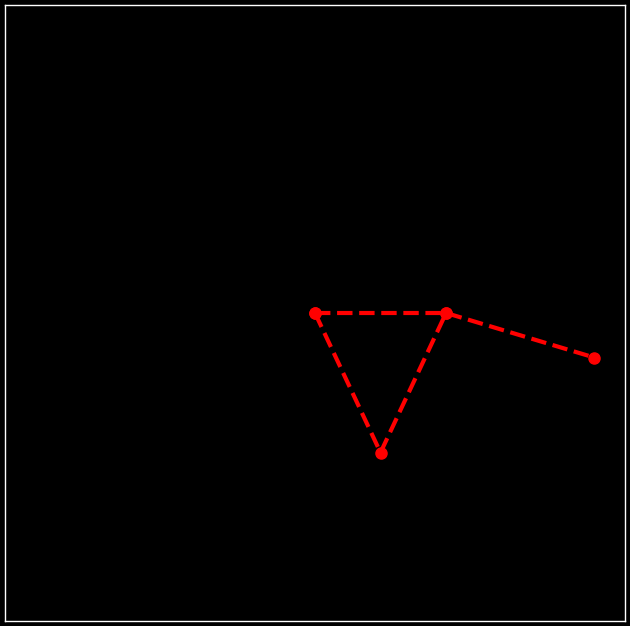

In [49]:
def animate(i):
    ln1.set_data([0, x1[i], x2[i], x3[i]], [0, y1[i], y2[i], y3[i]])
    ln2.set_data([0, x2[i]], [0, y2[i]])

fig, ax = plt.subplots(1, 1, figsize = (8, 8))

ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ln1, = plt.plot([], [], 'ro--', lw = 3, markersize = 8)
ln2, = plt.plot([], [], 'ro--', lw = 3, markersize = 8)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

ani = animation.FuncAnimation(fig, animate, frames = 1000, interval = 50)
ani.save('pen.gif', writer = 'pillow', fps = 25)